## Libraries

In [ ]:
!pip install python-magic

In [ ]:
import os
import ast
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import warnings
import magic
import glob
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Attempting to read the files in the directory as parquet files and concatenating them into a single DataFrame
extract_dir = '/content/drive/MyDrive/'

# Directory containing the parquet files
parquet_dir = os.path.join(extract_dir, 'model_input_003')

# Glob pattern to select all files within the directory
parquet_files = glob.glob(os.path.join(parquet_dir, '*'))

# Attempt to read each file as a parquet file and concatenate
try:
    df = pd.concat([pd.read_parquet(file) for file in parquet_files], ignore_index=True)
    print("Data loaded successfully.")
    df.head()
except Exception as e:
    print(f"Error occurred: {e}")
    df = None

Data loaded successfully.


In [ ]:
# Remove certain genres
to_remove = ['spoken', 'easy listening' , 'international' , 'instrumental']

df = df[~df['label'].isin(to_remove)]

# Display the first few rows
print(df.head())

# Check the DataFrame's structure
print(df.info())

   index track_id dataset                                         audio_path  \
1  97128   142128     fma  /project_data_source/free_music_archive/fma_sm...   
2  97129   142129     fma  /project_data_source/free_music_archive/fma_sm...   
3  97132   142132     fma  /project_data_source/free_music_archive/fma_sm...   
4  97133   142133     fma  /project_data_source/free_music_archive/fma_sm...   
5  97318   142358     fma  /project_data_source/free_music_archive/fma_sm...   

    label fma_genre_top fma_genres fma_genres_all  file_available  \
1    rock          Rock      [111]          [111]             1.0   
2    folk          Folk  [17, 103]      [17, 103]             1.0   
3    folk          Folk  [17, 103]      [17, 103]             1.0   
4    folk          Folk  [17, 103]      [17, 103]             1.0   
5  hiphop       Hip-Hop       [21]           [21]             1.0   

   sampling_rate                                           features  \
1        44100.0  [2183.0352, 0.1

## Models

### GridSearch with Best Parameters for Random Forest and XGBoost


In [ ]:
# Step 1: Safely evaluate the 'features' column
df['features'] = df['features'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

# Step 2: Drop rows with missing features
df = df.dropna(subset=['features'])

# Step 3: Prepare features and labels
X = np.stack(df['features'].values)  # Convert to numpy matrix
y = df['label'].values               # Extract labels

# Step 4: Encode labels into numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convert genres to numeric values

# Check the label encoding
print(f"Encoded Labels: {le.classes_}")

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Step 6: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 7: Define the parameter grids for Grid Search

# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# XGBoost parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# Step 8: Perform Grid Search on Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best Random Forest model and parameters
best_rf = rf_grid_search.best_estimator_
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

# Step 9: Perform Grid Search on XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
xgb_grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best XGBoost model and parameters
best_xgb = xgb_grid_search.best_estimator_
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

# Step 10: Evaluate both models on the test set

# Random Forest evaluation
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nBest Random Forest Accuracy:", accuracy_rf)
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))

# XGBoost evaluation
y_pred_xgb = best_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nBest XGBoost Accuracy:", accuracy_xgb)
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))

Encoded Labels: ['blues' 'classical' 'country' 'electronic' 'experimental' 'folk' 'hiphop'
 'jazz' 'oldtime / historic' 'pop' 'rock' 'soulrnb']
Training set size: (18697, 15)
Test set size: (4675, 15)
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:18:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Best Random Forest Accuracy: 0.585668449197861
Classification Report for Random Forest:
                     precision    recall  f1-score   support

             blues       0.50      0.54      0.52        39
         classical       0.55      0.81      0.65       134
           country       0.28      0.42      0.34        48
        electronic       0.68      0.55      0.61      1284
      experimental       0.38      0.47      0.42       442
              folk       0.42      0.63      0.51       313
            hiphop       0.51      0.60      0.55       457
              jazz       0.26      0.28      0.27        96
oldtime / historic       0.87      0.96      0.91        96
               pop       0.20      0.19      0.19       253
              rock       0.79      0.70      0.74      1473
           soulrnb       0.32      0.30      0.31        40

          accuracy       

### Weighted Soft Voting Ensemble with SMOTE for Improved Classification Performance (Random Forest and XGBoost)

In [ ]:
# Step 1: Safely evaluate the 'features' column
df['features'] = df['features'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

# Step 2: Drop rows with missing features
df = df.dropna(subset=['features'])

# Step 3: Prepare features and labels
X = np.stack(df['features'].values)  # Convert to numpy matrix
y = df['label'].values               # Extract labels

# Step 4: Encode labels into numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convert genres to numeric values

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 6: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Step 8: Define models with the best parameters
best_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,  # No limit on tree depth
    min_samples_split=2,
    random_state=42
)

best_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    subsample=0.8,
    eval_metric='mlogloss',
    random_state=42
)

# Step 9: Create the weighted soft voting ensemble
ensemble_model_weighted = VotingClassifier(
    estimators=[
        ('rf', best_rf),   # Random Forest
        ('xgb', best_xgb)  # XGBoost
    ],
    voting='soft',
    weights=[2, 3]  # Favor XGBoost due to higher performance
)

# Step 10: Train the ensemble model
ensemble_model_weighted.fit(X_train_balanced, y_train_balanced)

# Step 11: Make predictions on the test data
y_pred_weighted = ensemble_model_weighted.predict(X_test_scaled)

# Step 12: Evaluate the model's performance
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
classification_report_weighted = classification_report(y_test, y_pred_weighted, target_names=le.classes_)

# Output the results
print("Accuracy with Optimized Soft Voting Ensemble (RF + XGBoost):", accuracy_weighted)
print("Classification Report:\n", classification_report_weighted)

Accuracy with Optimized Soft Voting Ensemble (RF + XGBoost): 0.6158288770053476
Classification Report:
                     precision    recall  f1-score   support

             blues       0.50      0.56      0.53        39
         classical       0.64      0.73      0.69       134
           country       0.36      0.38      0.37        48
        electronic       0.65      0.65      0.65      1284
      experimental       0.41      0.38      0.40       442
              folk       0.52      0.60      0.56       313
            hiphop       0.56      0.57      0.56       457
              jazz       0.33      0.26      0.29        96
oldtime / historic       0.94      0.96      0.95        96
               pop       0.21      0.13      0.16       253
              rock       0.73      0.76      0.75      1473
           soulrnb       0.41      0.33      0.36        40

          accuracy                           0.62      4675
         macro avg       0.52      0.53      0.52     

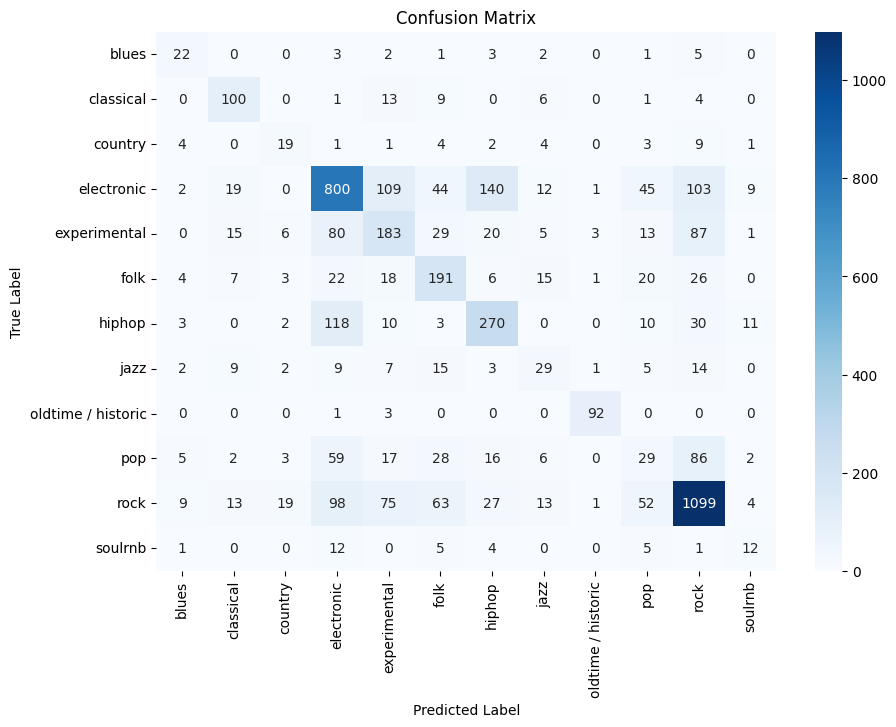

In [ ]:
# Step 13: Visualize the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_weighted)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Summary

#### Categories where the model performed well:
- **Rock**: 1,099 instances were correctly classified, showing a high level of accuracy in identifying rock music.
- **Electronic**: 800 instances were correctly classified, indicating strong performance in identifying electronic tracks.
- **Classical**: 100 instances were correctly classified, with minimal confusion with other genres.
- **Hip-hop**: 270 instances were correctly classified, showing reliable accuracy for this genre.
- **Oldtime / Historic**: 92 instances were correctly classified, with very little misclassification.

#### Categories with notable confusion:
- **Experimental**: Significant misclassification occurred with **Electronic** (109), **Pop** (87), and **Rock** (75).
- **Pop**: Confused with **Rock** (86 instances) and **Electronic** (59 instances), suggesting some overlap or similarity in features.
- **Jazz**: Misclassified as **Electronic** (29 instances) and **Experimental** (15 instances).
- **Soul/RnB**: Misclassified as **Electronic** (12 instances) and **Hip-hop** (5 instances), possibly due to genre similarities.

#### Observations:
- The model demonstrates strong performance with more distinct genres like **Rock** and **Classical**.
- Genres with overlapping features, such as **Experimental**, **Pop**, and **Electronic**, show higher misclassification rates, suggesting that these genres may share similar audio features that confuse the model.